In [1]:
from glob import glob
import sys, os, time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [3]:
%matplotlib inline

In [4]:
def get_fnames(method, measure, ext='csv'):
#     return glob(os.path.join(method, measure, "*.csv"))
    return glob(os.path.join(method, 'size_and_depth_counts', '*-{}.{}'.format(measure, ext)))

In [5]:
fnames = get_fnames('undirdir', 'size_counts')
s = pd.read_csv(fnames[0], index_col=0, squeeze=True)
max_row = s.index.max()
s = s.reindex(range(1, max_row+1)).fillna(0)
s



cl_size
1       61746
2       99082
3       42594
4       23213
5       15297
6       10645
7        7709
8        6005
9        4729
10       3878
11       3197
12       2684
13       2236
14       2015
15       1650
16       1525
17       1258
18       1102
19        982
20        917
21        831
22        720
23        695
24        582
25        544
26        468
27        422
28        412
29        367
30        320
        ...  
1634        0
1635        0
1636        0
1637        0
1638        0
1639        0
1640        0
1641        0
1642        0
1643        0
1644        0
1645        0
1646        0
1647        0
1648        0
1649        0
1650        0
1651        0
1652        0
1653        0
1654        0
1655        0
1656        0
1657        0
1658        0
1659        0
1660        0
1661        0
1662        0
1663        1
Name: num_clusters, dtype: float64

In [6]:
def get_count_series(fname):
    s = pd.read_csv(fname, index_col=0, squeeze=True)
    max_row = s.index.max()
    s = s.reindex(range(1, max_row+1)).fillna(0)
    return s

In [7]:
def mean_conf_interval(data, confidence=.9):
    # https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    return scipy.stats.t.interval(confidence, len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))

In [8]:
def get_overall_means(fnames, confidence=.9, num_trials=None):
    # if num_trials is none, it will use all of them
    vals = []
    if not num_trials:
        num_trials = len(fnames)
    max_numrows = 0
    for i in range(num_trials):
        fname = fnames[i]
        s = get_count_series(fname)
        if len(s) > max_numrows:
            max_numrows = len(s)
        vals.append(s)
    # make all of them the same size:
    for i in range(len(vals)):
        if len(vals[i]) < max_numrows:
            vals[i] = vals[i].reindex(range(1, max_numrows+1)).fillna(0)
        
    overall_means = np.mean(vals, axis=0)
    conf_lower, conf_upper = np.apply_along_axis(mean_conf_interval, axis=0, arr=vals, confidence=confidence)
    df_overall = pd.DataFrame({'num': vals[0].index, 'cl_count': overall_means, 
                        'conf_lower': conf_lower, 'conf_upper': conf_upper})
#     df_overall = pd.DataFrame({'num': vals[0].index, 'count': overall_means})
    df_overall.conf_lower = df_overall.conf_lower.fillna(df_overall.cl_count)
    df_overall.conf_upper = df_overall.conf_upper.fillna(df_overall.cl_count)
    return df_overall, num_trials

In [9]:
df, num_trials = get_overall_means(fnames)

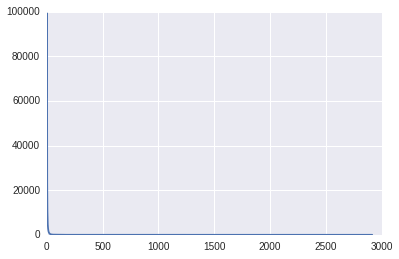

In [10]:
fig, ax = plt.subplots()
ax.plot(df.num, df.cl_count)

In [11]:
def get_plot(measure, confidence=.9, figsize=(12,8), return_dfs=False, num_trials=None):
    # measure can be "size_counts", "depth_counts"
    #
    # NOTE: this plots confidence interval of means across runs, NOT within runs
    fig, ax = plt.subplots(figsize=figsize)
    methods = ['undirdir', 'outdirdir', 'pagerank', 'pagerank_unrecorded']
    colors = ['black', 'orange', 'red', 'blue']
    dfs = []
    for i in range(len(methods)):
        method = methods[i]
        fnames = get_fnames(method, measure)
        df, num_trials = get_overall_means(fnames, confidence=confidence, num_trials=num_trials)
        ax.plot(df.num, df.cl_count, color=colors[i], label="{} (N={})".format(method, num_trials), linewidth=1, alpha=.2)
        ax.fill_between(df.num, df.conf_lower, df.conf_upper, color="gray", alpha=.1)
        if return_dfs:
            dfs.append(df)
#     ax.set_xbound(year_range)
    ax.legend(loc='best')
    ax.set_xlabel('num')
    ax.set_ylabel(measure)
    fig.suptitle(measure)
    if return_dfs:
        return fig, ax, dfs
    return fig, ax

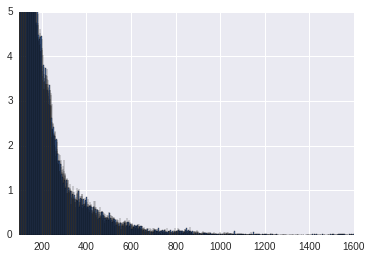

In [12]:
fig, ax = plt.subplots()
fnames = get_fnames('undirdir', 'size_counts')
df, num_trials = get_overall_means(fnames)
ax.bar(df.num, df.cl_count)
# ax.set_xscale('log')
ax.set_xlim(100,1600)
ax.set_ylim(0,5)
plt.show()

/share/apps/python/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


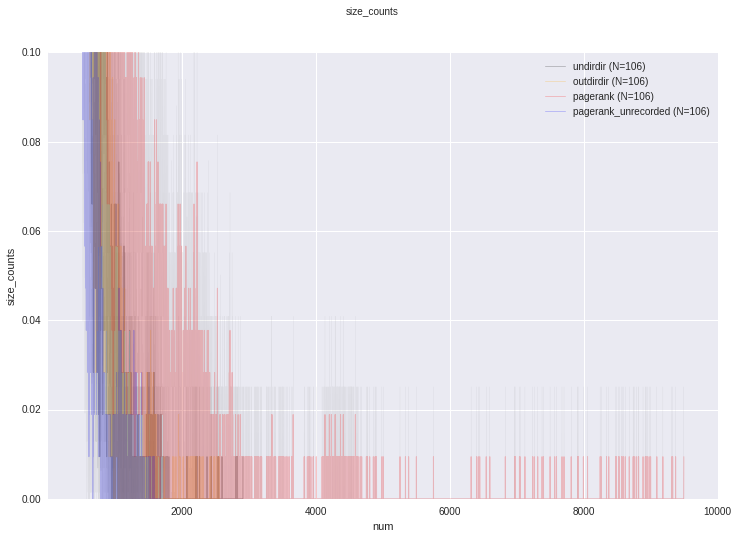

In [13]:
fig, ax = get_plot('size_counts')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,10)
ax.set_xlim(left=10)
ax.set_ylim(0,.1)

plt.show()

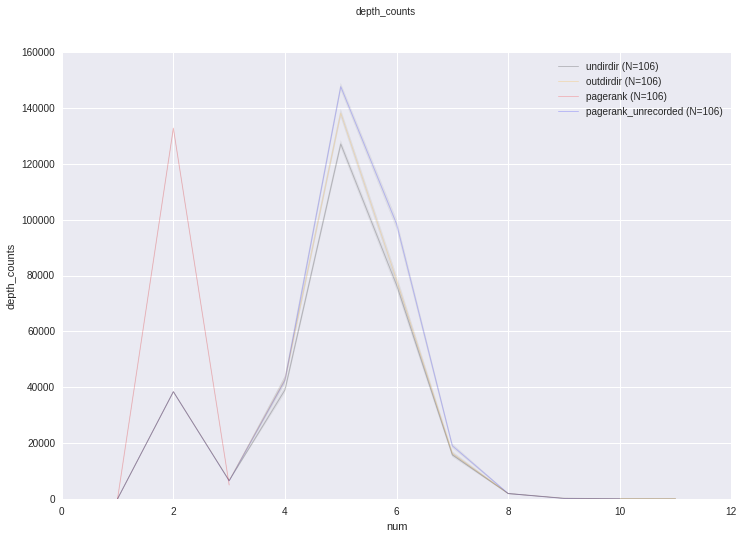

In [14]:
fig, ax = get_plot('depth_counts')
plt.show()

In [22]:
def _return_first_df(method):
    fnames = get_fnames(method, 'node_size_depth')
    df = pd.read_csv(fnames[0])
    return df

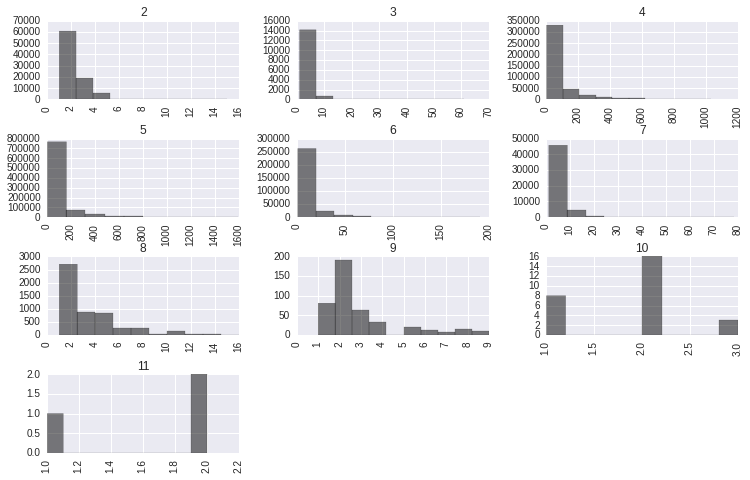

In [42]:
df = _return_first_df('undirdir')
axes = df.hist(column='cl_size', by='cl_depth', alpha=.5, color='black', figsize=(12,8))

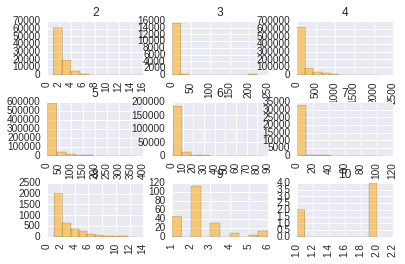

In [29]:
df = _return_first_df('outdirdir')
axes = df.hist(column='cl_size', by='cl_depth', alpha=.5, color='orange')

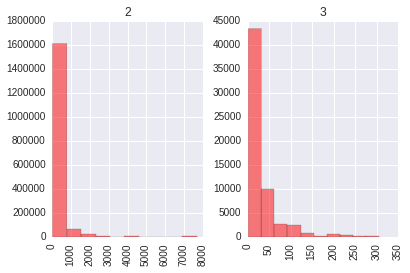

In [30]:
df = _return_first_df('pagerank')
axes = df.hist(column='cl_size', by='cl_depth', alpha=.5, color='red')

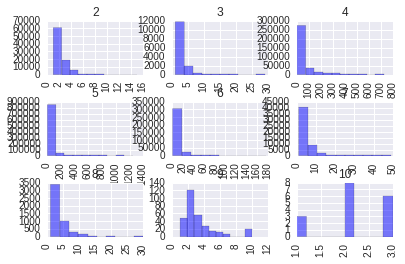

In [31]:
df = _return_first_df('pagerank_unrecorded')
axes = df.hist(column='cl_size', by='cl_depth', alpha=.5, color='blue')

In [39]:
ax = axes[0][0]
ax.title.get_text()

u'2'